# Kaggle Competition Notebook: Titanic Survival Prediction

- Author: Sumit Sharma
- Github: #
- LinkedIn: #
- Kaggle: #
- Email: sumit8444061@gmail.com


# Survival Rate Predicted by Neural Network in TensorFlow

In [86]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [87]:
# load the data
df_train = pd.read_csv('./Data/train.csv')
df_test = pd.read_csv('./Data/test.csv')
df_submission = pd.read_csv('./Data/gender_submission.csv')

In [88]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [89]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [90]:
df_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Let's explore the data df_train.csv

In [91]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


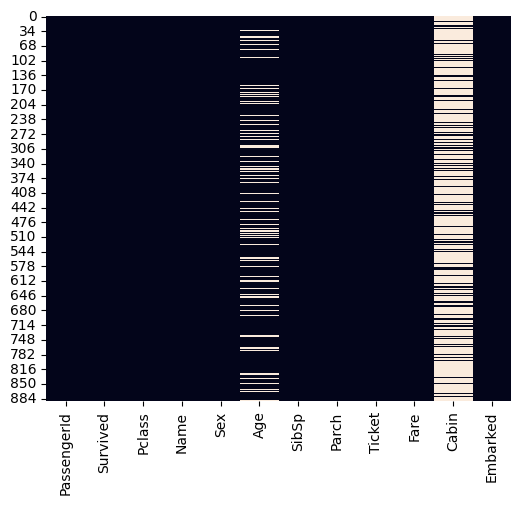

In [92]:
# lets plot the null values
plt.figure(figsize=(6, 5))
sns.heatmap(df_train.isnull(), cbar=False)
plt.show()

In [93]:
((df_train.isnull().sum() / len(df_train)) * 100).sort_values(ascending=False)

Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64

#### Imputing missing values using ML models

In [94]:
df = df_train.copy()

In [95]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [96]:
# import libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()

categorical_cols = ['Cabin', 'Embarked']
bool_cols = []
numeric_cols = ['Age']

# define the function to impute the missing values in thal column

def impute_categorical_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

import warnings
warnings.filterwarnings('ignore')

# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass
    
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Missing Values Age : 19.87%
MAE = 9.070640559440559 

RMSE = 11.455424532087392 

R2 = 0.2922126320824735 

Missing Values Cabin : 77.1%
The feature 'Cabin' has been imputed with 21.95 accuracy

Missing Values Embarked : 0.22%
The feature 'Embarked' has been imputed with 89.89 accuracy



Series([], dtype: int64)

In [97]:
# split the data in features and target
X = df.drop(['Survived','Name'], axis=1)
y = df['Survived']

# encode the categorical columns
label_encoder = LabelEncoder()

for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype == 'category':
        X[col] = label_encoder.fit_transform(X[col])
    else:
        pass
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




## Create a nueral network for binary classification

In [98]:
# use tensorflow to build a neural network
import tensorflow as tf


# Create the model

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)), # input layer
    tf.keras.layers.Dense(32, activation='relu'), # hidden layer
    tf.keras.layers.Dense(1, activation='sigmoid') # output layer
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate the model
model.evaluate(X_test, y_test)

Epoch 1/100
23/23 [==============================] - 1s 11ms/step - loss: 3.0511 - accuracy: 0.5295 - val_loss: 2.2272 - val_accuracy: 0.5922
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 2.1986 - accuracy: 0.5674 - val_loss: 2.3308 - val_accuracy: 0.3966
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 1.5210 - accuracy: 0.5871 - val_loss: 1.2210 - val_accuracy: 0.5978
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 1.2896 - accuracy: 0.5674 - val_loss: 0.9905 - val_accuracy: 0.6089
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.8481 - accuracy: 0.6053 - val_loss: 0.8243 - val_accuracy: 0.6369
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.8710 - accuracy: 0.6138 - val_loss: 0.8129 - val_accuracy: 0.6648
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9321 - accuracy: 0.6208 - val_loss: 0.6743 - val_accuracy: 0.6872
Epoch 8/100


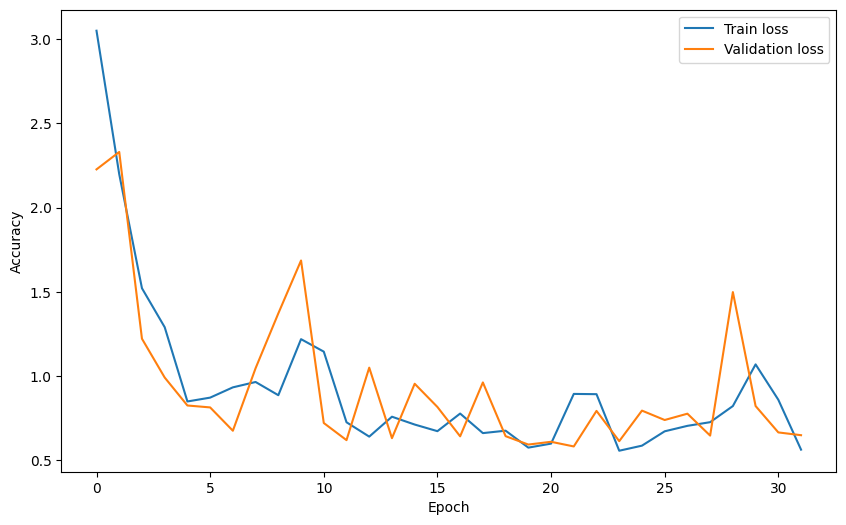

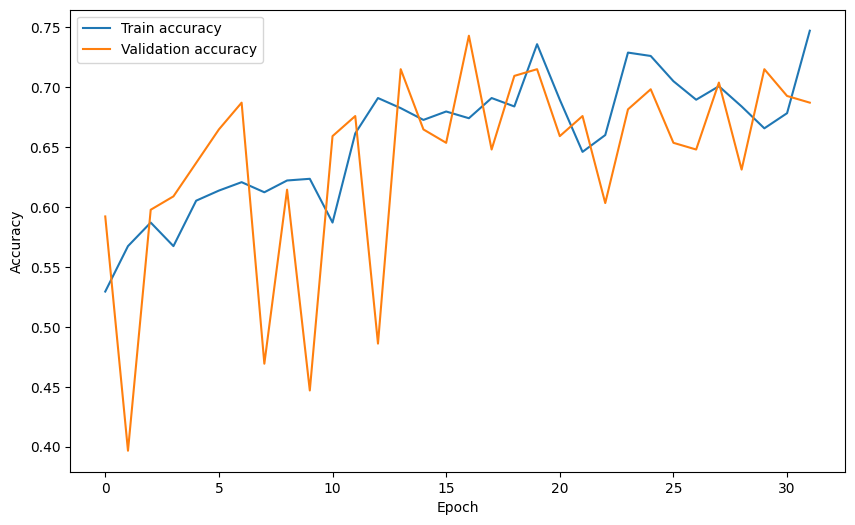

In [99]:
# importing callback to stop training when the model reaches a certain accuracy
from tensorflow.keras.callbacks import EarlyStopping

# Create early stopping callback
early_stopping = EarlyStopping(patience=10)

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

# plot the training and testing loss and accuracy at each epoc
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(history.history['loss'], label='Train loss')
ax.plot(history.history['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(history.history['accuracy'], label='Train accuracy')
ax.plot(history.history['val_accuracy'], label='Validation accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()